![Logo.png](Images/Logo.png)



#### 0. [Setup](#0) 
   - [0.1 Import Packages](#0.1)  
   - [0.2 Connect to Snowflake](#0.2) 
   - [0.3 Gathering Data as Snowpark DataFrame](#0.3)


#### 1. [Data Exploration](#1)
   - [1.1 K-Means Clustering](#1.1)  
      - [1.1.1 Joining the Data](#1.1.1)  
         - [1.1.1.1 Define function - Remove Duplicate Columns from Joins](#1.1.1.1)  
         - [1.1.1.2 Join Members Data with Orders_V](#1.1.1.2)  
      - [1.1.2 Generate RFN table (K-Means Specific)](#1.1.2)  
      - [1.1.3 Outlier Handling (K-Means Specific)](#1.1.3)  
      - [1.1.4 Feature Scaling (K-Means Specific)](#1.1.4)  
      - [1.1.5 Building K-Means model](#1.1.5)  
      - [1.1.6 Improving the K-Means model](#1.1.6)  
   - [1.2 Visualise the Data](#1.2) 
      - [1.2.1 Total number of Transactions](#1.2.1) 
      - [1.2.2 Members in Country](#1.2.2) 
      - [1.2.3 Total number of Transactions](#1.2.3) 
   - [1.3 Churn Rate by Country](#1.3) 
      - [1.3.2 Calculate Churn Rate by Country](#1.3.2)
      - [1.3.3 Visualise Churn Rate](#1.3.0)
   
#### 2. [Joining Tables](#2) 
   - [2.1 Define functions](#2.1)  
      - [2.2.1 Remove Duplicate Columns from Joins](#2.2.1)
   - [2.2 Join Members Data with Orders_V](#2.2)
      - [2.2.1 Inner Join Tables](#2.2.1)
      - [2.2.2 Remove Duplicates](#2.2.2)

#### 3. [Data Engineering](#3)
   - [3.1 Generate new Columns](#3.1)  
      - [3.1.1 Get Latest Order Date](#3.1.1)
      - [3.1.2 RFM (Recency, Freqency, Monetary)](#3.1.2)
      - [3.1.3 Average Time Difference, Max and Min Days without Purchase](#3.1.3)
      - [3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country](#3.1.4)
      - [3.1.5 Join Generated Variables](#3.1.5)
      - [3.1.6 Days to Next Order](#3.1.6)
      - [3.1.7 Filter to selected Country](#3.1.7)
   - [3.2 Outlier Handling](#3.2)  
      - [3.2.1 Identify Numericals](#3.2.1)
      - [3.2.2 Visualise Outliers](#3.2.2)
      - [3.2.3 Cap the Outliers](#3.2.3)
         - [3.2.3.1 Cap by IQR](#3.2.3.1)
         - [3.2.3.2 Cap by Gaussian](#3.2.3.2)
   - [3.3 Numerical Transformation](#3.3)
      - [3.3.1 Visualise Numericals](#3.3.1)
      - [3.3.2 YeoJohnson Transformer](#3.3.2)
   - [3.4 Generate Target Variable](#3.4)
   - [3.5 Sample the Data](#3.5)
      - [3.5.1 Stratified Sampling](#3.5.1)

#### 4. [Split the Data](#3)
   - [4.1 Data Engineering 2](#4.1)  
      - [4.1.1 Categorical Encoding](#4.1.1)
         - [4.1.1.1 One Hot Encoding](#4.1.1.1)
         - [4.1.1.2 Clean the Encoded Columns](#4.1.1.2)
      - [4.1.2 Feature Scaling](#4.1.2)
         - [4.1.2.1 Min Max Scaler](#4.1.2.1)
      - [4.1.3 Drop Target Variable](#4.1.3)  

#### 5. [Model Building](#5) 
   - [5.1 Define Evaluation Function](#5.1)  
   - [5.2 Logistic Regression](#5.2)
      - [5.2.1 Build the model](#5.2.1)
      - [5.2.2 Improve the model](#5.2.2)
   - [5.3 Decision Tree](#5.3)
      - [5.3.1 Build the model](#5.3.1)
      - [5.3.2 Improve the model](#5.3.2)
   - [5.4 Random Forest](#5.4)
      - [5.4.1 Build the model](#5.4.1)
      - [5.4.2 Improve the model](#5.4.2)
   - [5.5 Adaboost](#5.5)
      - [5.5.1 Build the model](#5.5.1)
      - [5.5.2 Improve the model](#5.5.2)
   - [5.6 XGboost (Final Model)](#5.6)
      - [5.6.1 Build the model](#5.6.1)
      - [5.6.2 Improve the model](#5.6.2)
   
#### 6. [Model Comparison](#6)
   - [6.1 Model Accuracies](#6.1)  

#### 7. [Machine-Learning with Snowflake ](#7) 
   - [7.1 Create the Stage ](#7.1)  
   - [7.2 Create Tables](#7.2)  
   - [7.3 Create Final Model ](#7.3) 
   - [7.4 Model Training](#7.4)
   - [7.5 Model Deployment](#7.5)
      - [7.5.1 Create a User-Defined Function for Model Inference](#7.5.1) 
      - [7.5.2 Run UDF](#7.5.2) 
         - [7.5.2.1 Evaluation](#7.5.2.1)


# Overview
We are part of the data team at Snowflake. Snowflake is a provider of cloud-based data platform based in Singapore that offers scalable, cloud-based data processing, analytics and machine learning services that can integrate with a wide range of other tools enabling users to build and deploy models for predictive analytics and AI applications. 

The customer is Tasty Bytes, one of the largest food truck networks in the world with localized menu options spread across 30 major cities in 15 countries. In the inception deck, we have identified the following pain points: 

●   Customer Churn is quite high, at ~33% of all customers churned over a 3 year period<br>
●   Customer Churn is at ~50% in a 1 month period<br>
●   Membership sign up growth is stagnant with no upward trend<br>

This means that Tasty Bytes has a unsustainable churn rate and may result in market shrinkage in the future. Moreover, their long term goals are as follows:

![tasty_byte_goals.jpg](Images/tasty_byte_goals.jpg)

For our Proof of Concept (POC), we will be focusing on the Sales and NPS metrics in particular

![tasty_byte_goals_focus.jpg](Images/tasty_byte_goals_focus.jpg)

To help Tasty Bytes address their pain points and reach their goals, we have come up with a solution, which will be to create a user-friendly customer analytics platform that provides key insights on customer behavior to improve retention and drive growth. 

To accomplish this, the following steps will be taken

●   Create an unsupervised learning model to segment our customers<br>
●   To discover and gain a deeper understanding of our customer’s preferences <br>
●   Integrate the Machine-Learning model and key visualizations into streamlit web application<br>

In this juypter notebook, we will be creating an unsupervised learning model to segment Tasty Byte's customers by their churn

# 0. Setup

## 0.1 Import Packages

In [1]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# model selection
from sklearn.model_selection import GridSearchCV

# for feature selection
from sklearn.feature_selection import SelectFromModel

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## 0.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 0.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("frostbyte_tasty_bytes_setup_s.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("frostbyte_tasty_bytes_setup_s.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 1. Data Exploration 

# 1.0.1 Model Value Towards Tasty Byte KPI

The initial objectives of the model is to work towards improving two main KPI's. This section includes information regarding the correlation of identifying customer churn (or in the case of this stage, days to next order).

The idea behind our model is that by identifying when customers will churn the marketing team can take steps to carry out targeted marketing to be able to prevent that and in turn improve NPS score and Sales YOY

In [5]:
# gather NPS required columns to analyse
SENTIMENT = TRUCK_DATA.join(SENTIMENT_DATA, SENTIMENT_DATA["TRUCK_ID"] == TRUCK_DATA["TRUCK_ID"], "inner")

SENTIMENT2 = SENTIMENT.dropna()

# setting up NPS Score by year, month and specific year months to compare
AVG_NPS_SCORE = SENTIMENT2.with_column("YEAR", F.year("SURVEY_TS"))
AVG_NPS_SCORE = AVG_NPS_SCORE.with_column("MONTH", F.month("SURVEY_TS"))
AVG_NPS_SCORE = AVG_NPS_SCORE.with_column("YEAR_MONTH", F.concat(F.col("YEAR"), F.col("MONTH")))

AVG_NPS_SCORE_YEAR = AVG_NPS_SCORE.groupBy(F.col("YEAR")).agg(F.avg("NPS_SCORE"))
AVG_NPS_SCORE_MONTH = AVG_NPS_SCORE.groupBy(F.col("MONTH")).agg(F.avg("NPS_SCORE"))
AVG_NPS_SCORE_YM = AVG_NPS_SCORE.groupBy(F.col("YEAR"), F.col("MONTH")).agg(F.avg("NPS_SCORE"))

# setting up comparison table (i.e. DTNO to KPI)
NPS_COMPARE = NPS_COMPARE.with_column("YEAR", F.year("DATE"))
NPS_COMPARE = NPS_COMPARE.with_column("MONTH", F.month("DATE"))
NPS_COMPARE = NPS_COMPARE.with_column("YEAR_MONTH", F.concat(F.col("YEAR"), F.col("MONTH")))

AVG_DTNO_YEAR = NPS_COMPARE.groupBy(F.col("YEAR")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))
AVG_DTNO_MONTH = NPS_COMPARE.groupBy(F.col("MONTH")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))
AVG_DTNO_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))

AVG_SALES_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.avg('"ORDER_TOTAL"'))
SUM_SALES_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.sum('"ORDER_TOTAL"'))

Here we are comparing the average days to next order, which is what our model is predicting for in terms of the churn value, with the average net promoter score of the respective year. We can see that there exists a correlation that does not fit what we had set out to achieve.

There is a positive correlation between the two values across the years and that is reflected as well when taking a look at the month and year month levels (Which is not shown in the jupyter notebook).

It is expected that the two values do not have the correlation that we were looking for and hence we will be dropping the NPS as our target for this model due to this finding.

In [6]:
# comparing the NPS with the DTNO VALUE
DTNO_TO_NPS_YEAR = AVG_DTNO_YEAR.join(AVG_NPS_SCORE_YEAR, AVG_DTNO_YEAR["YEAR"] == AVG_NPS_SCORE_YEAR["YEAR"])

DTNO_TO_NPS_YEAR.show()

---------------------------------------------------------------------------------
|"l_ehr7_YEAR"  |"AVG(DAYS_TO_NEXT_ORDER)"  |"r_80m0_YEAR"  |"AVG(NPS_SCORE)"   |
---------------------------------------------------------------------------------
|2021           |16.843626                  |2021           |70.78996630475477  |
|2020           |24.773306                  |2020           |82.65104808877929  |
|2022           |12.569290                  |2022           |73.91523935002196  |
|2019           |43.885027                  |2019           |89.78290366350068  |
---------------------------------------------------------------------------------



On the other hand we do see that the average days to next orders has a relationship with average sales by month that we can work with.

We see that when the average days to next orders increase the total sales within the month decrease, and when average days to next orders decrease the total sales increase this means the customer recursion matters to the revenue.

This acts as a proxy value to the KPI of revenue and ties our models output towards achieving company goals. As by taking actions to reduce the days to next order or churn rate down we can maximise our profits through creating loyal customers and encouraging customers to use the service more.

In [7]:
SALES_VS_DTNO = SUM_SALES_YM.join(AVG_DTNO_YM, (SUM_SALES_YM["YEAR"] == AVG_DTNO_YM["YEAR"])&(SUM_SALES_YM["MONTH"] == AVG_DTNO_YM["MONTH"]))
SALES_VS_DTNO.show()

--------------------------------------------------------------------------------------------------------------------
|"l_j512_YEAR"  |"l_j512_MONTH"  |"SUM(ORDER_TOTAL)"  |"r_s51b_YEAR"  |"r_s51b_MONTH"  |"AVG(DAYS_TO_NEXT_ORDER)"  |
--------------------------------------------------------------------------------------------------------------------
|2020           |6               |9401264.2500        |2020           |6               |25.202461                  |
|2020           |8               |10945427.7500       |2020           |8               |23.566927                  |
|2021           |7               |16620161.2500       |2021           |7               |16.780414                  |
|2021           |11              |18665928.2500       |2021           |11              |14.707342                  |
|2020           |12              |13382712.0000       |2020           |12              |20.739423                  |
|2019           |4               |213301.5000         |2019     

## 1.1 K-Means Clustering

### 1.1.1 Joining the Data

#### 1.1.1.1 Define function - Remove Duplicate Columns from Joins

In [8]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

#### 1.1.1.2 Join Members Data with Orders_V

In [9]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

### 1.1.2 Generate RFN table (K-Means Specific)

In [11]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = remove_dup.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = remove_dup.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = remove_dup.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

In [12]:
#Convert RFM Table to pandas and drop ORDER_TS
X=RFM_table.to_pandas()
X=X.drop(['ORDER_TS','CUSTOMER_ID'],axis=1,errors='ignore')
X.head()

,RECENCY,FREQUENCY,MONETARY
0,8,62,2300.5
1,5,58,2528.0
2,2,50,1399.5
3,6,60,2743.0
4,1,59,2005.0


### 1.1.3 Outlier Handling (K-Means Specific)

<b>Outlier handling increased the models inertia/SSE, therefore it is in markdown.

#create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','MONETARY'])

windsorizer.fit(X)
X_win = windsorizer.transform(X)

#create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY'])

windsorizer.fit(X_win)
X_win=windsorizer.transform(X_win)

### 1.1.4 Feature Scaling (K-Means Specific)

In [13]:
# Scaling the data so that all the features/attributes become comparable 
MinMax = MinMaxScaler()
X_scaled_MinMax=MinMax.fit_transform(X)


### 1.1.5 Building K-Means model

In [14]:
#Build kmeans for min max scaled data
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_MinMax)

kmeans.inertia_

2859.313671679603

### 1.1.6 Improving the K-Means model

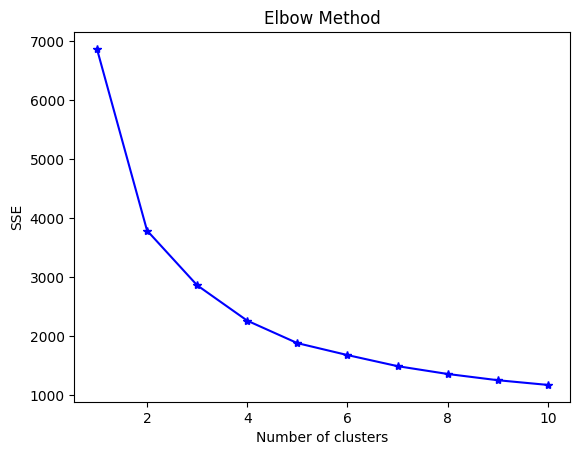

In [15]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(X_scaled_MinMax)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [16]:
kmeans = KMeans(n_clusters=5, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_MinMax)

kmeans.inertia_

1878.8094198783444

## 1.2 Visualise the Data

### 1.2.1 K-Means Clusters

RECENCY


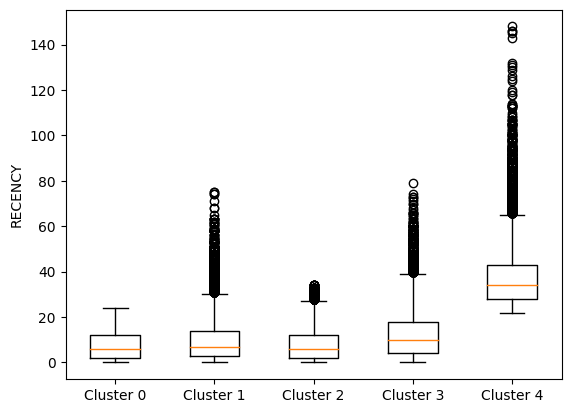

FREQUENCY


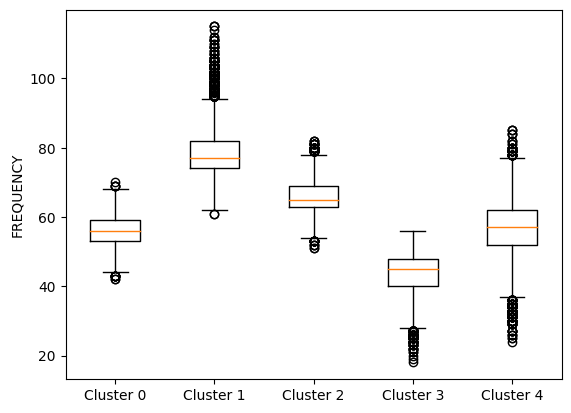

MONETARY


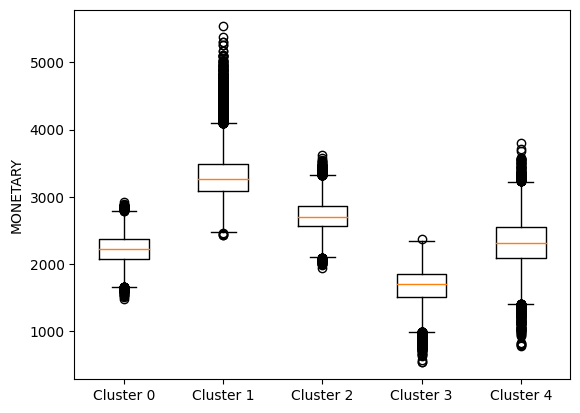

In [17]:
y_pred = kmeans.fit_predict(X_scaled_MinMax)

X['Cluster']=y_pred

# Groupped Boxplots
col_index = 0

for col in X: 
    
    boxplots = []
    clustername = []

    for cluster_index in range(X['Cluster'].nunique()):
        boxplots.append(X.iloc[:,col_index][X.Cluster==cluster_index].tolist())
        clustername.append('Cluster ' + str(cluster_index))
        
    print(col) 
    plt.cla()
    plt.ylabel(col)
    plt.boxplot(boxplots,
                 labels=clustername)    
    plt.show()
    col_index=col_index+1

Write Description

### 1.2.2 Members in Country

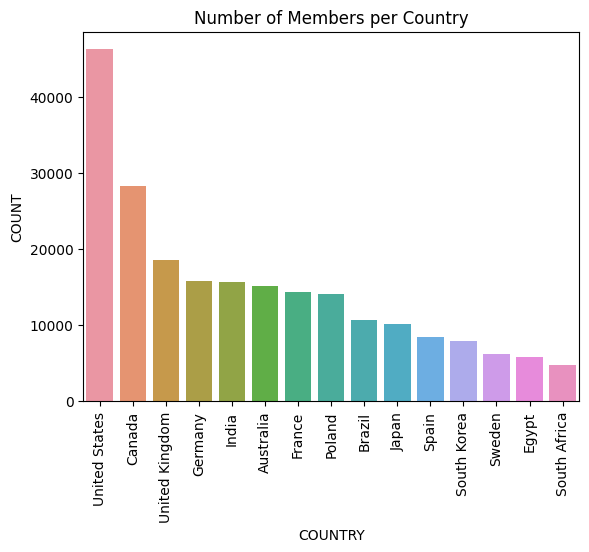

In [18]:
# Unique members
unique_Members=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=unique_Members)
plt.xticks(rotation=90)
plt.title('Number of Members per Country')
plt.show()

### 1.2.3 Total number of Transactions

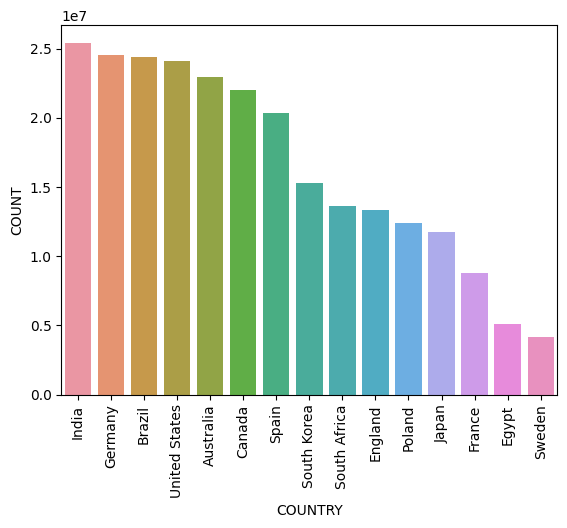

In [19]:
# Number of unique transactions
unique_Transactions=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=unique_Transactions)
plt.xticks(rotation=90)
plt.title('')
plt.show()

## 1.3 Churn Rate by Country

### 1.3.1 Get Churn Cut Off date by Country

In [77]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)

#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)

### 1.3.2 Calculate Churn Rate by Country

In [78]:
#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]

#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
churn_Rate=calc.sort_values(by='CHURN_RATE',ascending=False)

### 1.3.3 Visualise Churn Rate

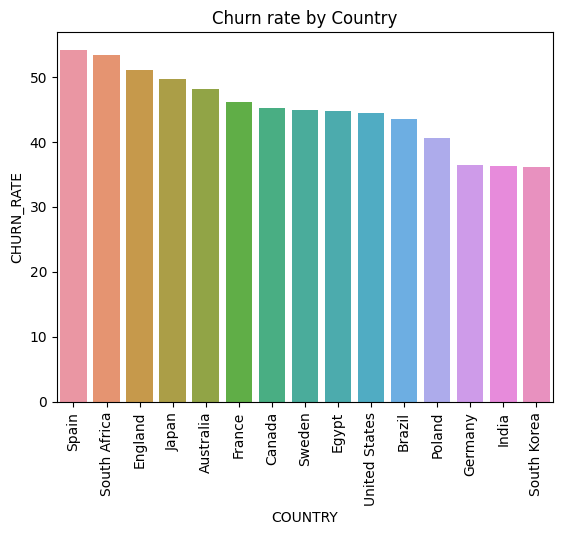

In [79]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=churn_Rate)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

<b>We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

# 3. Data Engineering

## 3.1 Generate new Columns

### 3.1.1 Get Latest Order Date

In [23]:
# called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

#Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

In [24]:
#Rename columns
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [25]:
#Merge with second max order dataframe
max_Order=remove_dup.join(right=max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = max_Order.filter(F.col('ORDER_TS') < F.col('Max_Order_TS'))


In [26]:
#Display last recorded purchase globally
tasty_bytes_orders_v.select(F.max('ORDER_TS')).show()

-----------------------
|"MAX(""ORDER_TS"")"  |
-----------------------
|2022-11-01 22:59:59  |
-----------------------



### 3.1.2 RFM (Recency, Freqency, Monetary)

In [27]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

### 3.1.3 Average Time Difference, Max and Min Days without Purchase

In [28]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer and menu item
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

#Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

### 3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country

In [29]:
#Get Customer demographic
cust_demo=tasty_bytes_customer_loyalty.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS','COUNTRY')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

cust_demo.show()


--------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"  |"COUNTRY"      |"AGE"  |
--------------------------------------------------------------------------------------------
|66             |1982-11-24       |Male         |Married           |Canada         |40     |
|118            |1988-06-13       |Male         |Single            |United States  |34     |
|131            |1984-12-29       |Male         |Single            |Canada         |38     |
|132            |1981-04-30       |Male         |Single            |Canada         |41     |
|171            |1987-08-06       |Male         |Single            |Canada         |35     |
|189            |1984-03-05       |Undisclosed  |Married           |United States  |38     |
|195            |1987-08-17       |Female       |Single            |Canada         |35     |
|204            |1979-06-25       |Male         |Undisclosed       |Un

### 3.1.5 Join Generated Variables

In [30]:
#Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')

### 3.1.6 Days to Next Order

In [31]:
#Convert timestamp to date such that Days to next orders is more accurate
final_df=final_df.with_column('ORDER_TS',F.to_date(F.col('ORDER_TS')))
final_df=final_df.with_column('MAX_ORDER_TS',F.to_date(F.col('MAX_ORDER_TS')))

In [32]:
#Add Days To Next Order
final_df = final_df.withColumn('Days_To_Next_Order', F.datediff(col1=final_df['ORDER_TS'], col2=final_df['MAX_ORDER_TS'],part='day'))

In [33]:
#Get median of Days to next order
final_df.select(F.median('DAYS_TO_NEXT_ORDER')).show()

------------------------------------
|"MEDIAN(""DAYS_TO_NEXT_ORDER"")"  |
------------------------------------
|9.000                             |
------------------------------------



*We'll create a target variable based on whether customers purchase below or above the median number of days since their prior order. 'Not churn' will indicate purchases below the median, while 'Churn' will represent purchases above the median. This helps identify customers for retention strategies and predicts their engagement with our business.

The median days to next order is 9 for customers from all countries, this will be used to check if our train dataset's target variable is representative of the global dataset.

### 3.1.7 Filter to selected Country

In [34]:
#Filter to United States
final_df=final_df.filter(F.col('COUNTRY')=='United States')

In [35]:
#Drop CustomerID
final_df=final_df.drop('CUSTOMER_ID')

In [36]:
#Convert to pandas
final_df=final_df.to_pandas()

## 3.2 Outlier Handling

### 3.2.1 Identify Numericals

In [37]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns

### 3.2.2 Visualise Outliers

In [38]:
#Function to explore the distributuion of variables
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    fig=plt.figure(figsize=(12, 4))
    fig.suptitle(variable)
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

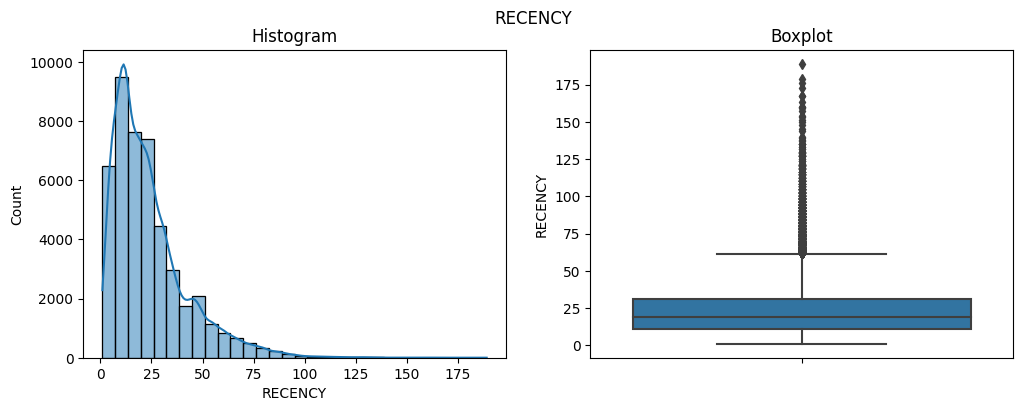

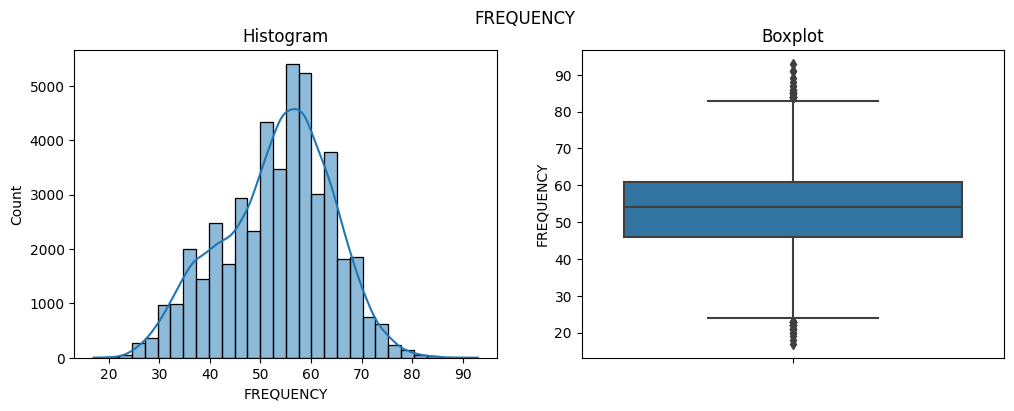

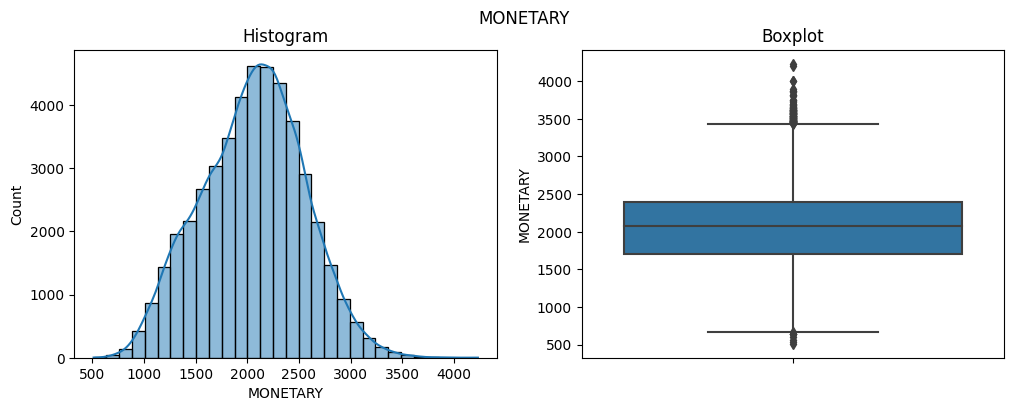

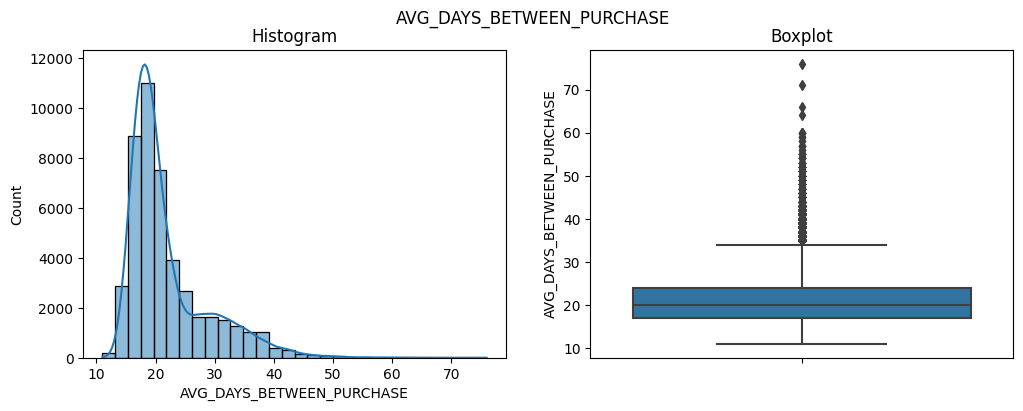

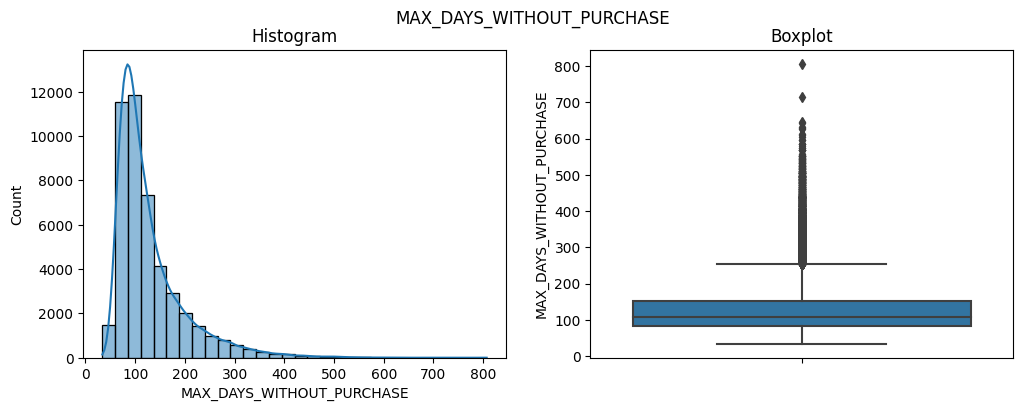

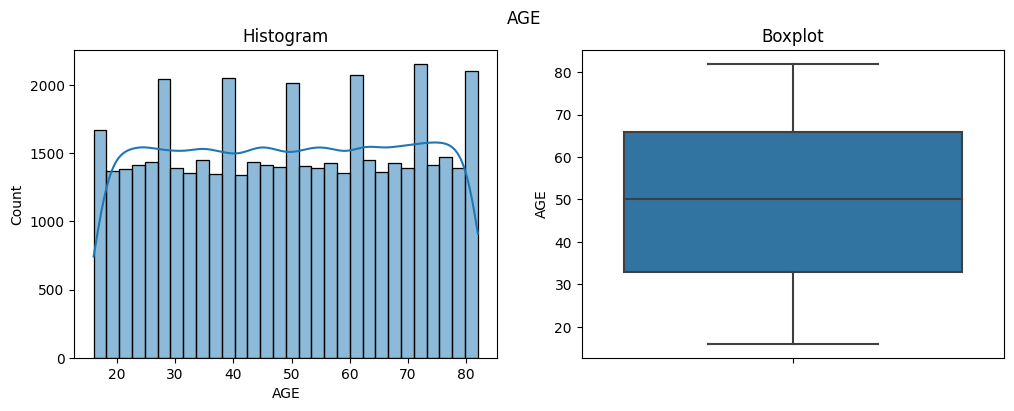

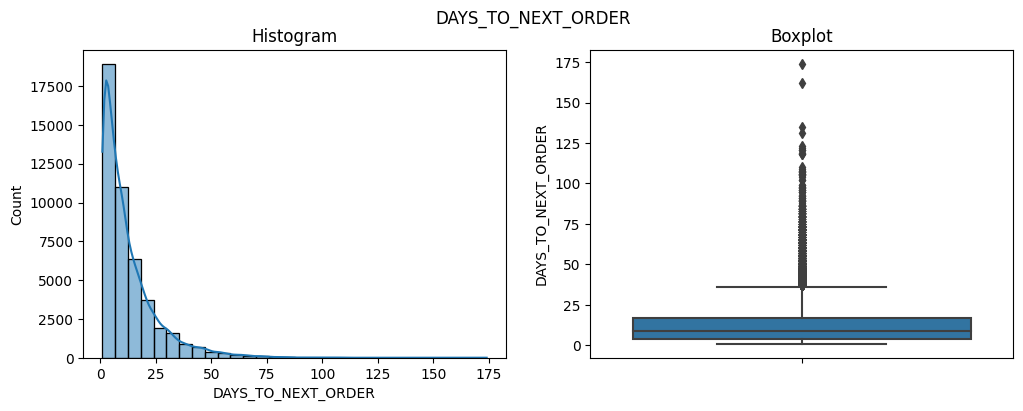

In [39]:
for i in num_cols.drop('MIN_DAYS_WITHOUT_PURCHASE'):
    diagnostic_plots(final_df,i)
    plt.show()

From the histograms, we find that Recency, Average days between purchase, Maximum days without purchase and days to next order columns have a right skewed distribution. While Frequency and Monetary have quite a normal distribution.

*Note there is no point dealing with outliers in Days to next order as even when dealt with, the 50% mark stays the same, meaning no change to our target variable.

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by IQR

In [40]:
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

#### 3.2.3.2 Cap by Gaussian

In [41]:
final_df_win = windsorizer.transform(final_df)

In [42]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','MONETARY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'MONETARY'])

In [43]:
final_df_win = windsorizer.transform(final_df_win)

## 3.3 Numerical Transformation

### 3.3.1 Visualise Numericals

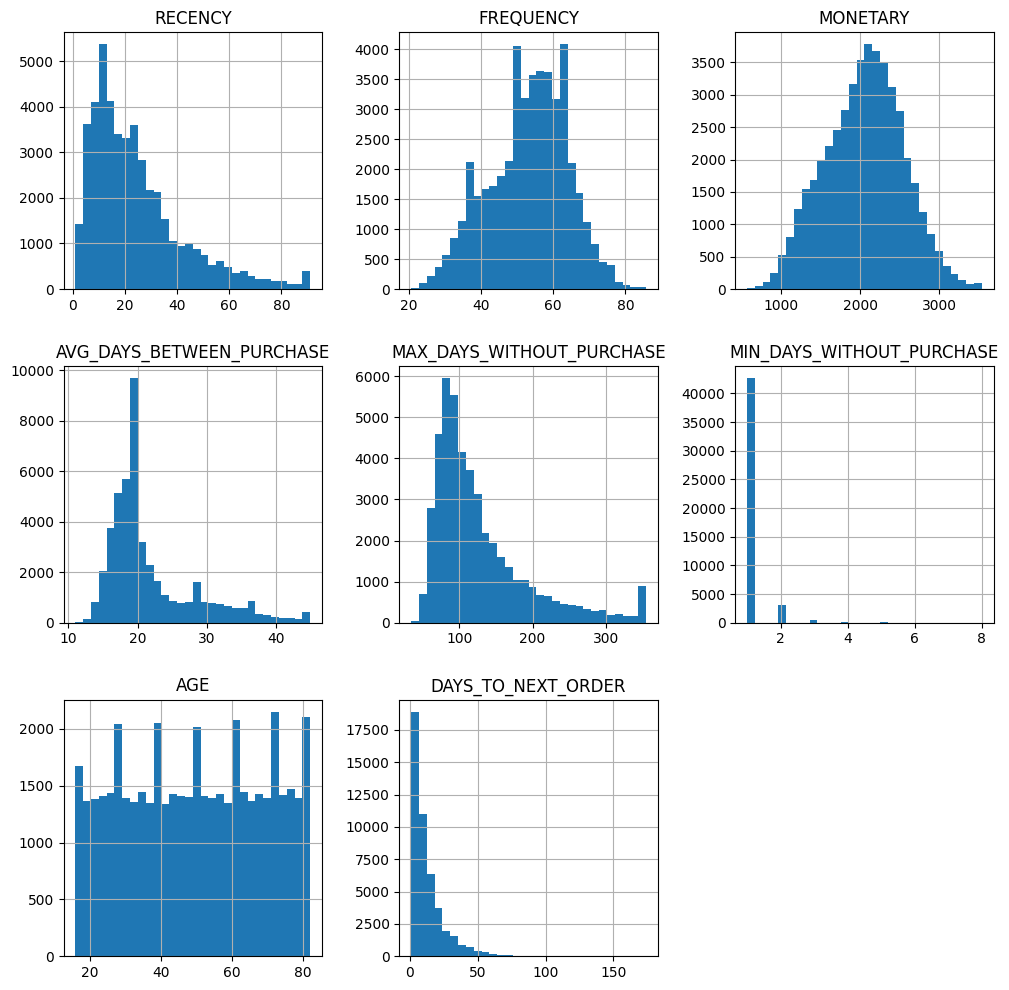

In [44]:
# plot the histogram to inspect variable distributions (not in book)

final_df_win.hist(bins=30, figsize=(12,12))
plt.show()

### 3.3.2 YeoJohnson Transformer

In [45]:
# select variables to transform in a list
cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE', 'MIN_DAYS_WITHOUT_PURCHASE']

# initialize the transformer with a subset of variables to transform
yjt = YeoJohnsonTransformer(variables = cols)

# fit transformer to the dataframe
yjt.fit(final_df_win)

YeoJohnsonTransformer(variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                                 'MAX_DAYS_WITHOUT_PURCHASE',
                                 'MIN_DAYS_WITHOUT_PURCHASE'])

In [46]:
# transform indicated variables
final_df_yjt = yjt.transform(final_df_win)

## 3.4 Generate Target Variable

In [47]:
#Describe the target
final_df_yjt['DAYS_TO_NEXT_ORDER'].describe()

count    46300.000000
mean        12.572959
std         12.840417
min          1.000000
25%          4.000000
50%          9.000000
75%         17.000000
max        174.000000
Name: DAYS_TO_NEXT_ORDER, dtype: float64

In [48]:
#Add Target Variable Next Purchase Day Range 
final_df_yjt['CHURNED'] = 1
final_df_yjt.loc[final_df_yjt['DAYS_TO_NEXT_ORDER']<=9,'CHURNED'] = 0

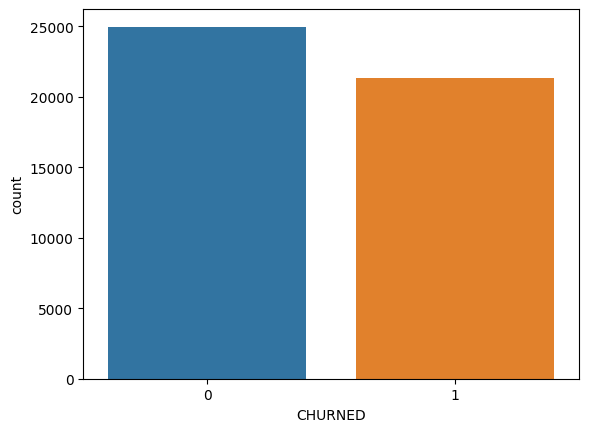

In [49]:
#Distribution of target variable
sns.countplot(data=final_df_yjt,x='CHURNED')
plt.show()

## 3.5 Sample the Data

### 3.5.1 Stratified Sampling

In [50]:
df1=final_df_yjt[final_df_yjt['CHURNED']==1]
len(df1)

21328

In [51]:
df0=final_df_yjt[final_df_yjt['CHURNED']==0]
len(df0)

24972

In [52]:
#Perform Stratified Sampling
df0_sampled = df0.sample(n=len(df1), random_state=4).copy()
df_new=pd.concat([df1,df0_sampled],axis=0)
df_new['CHURNED'].value_counts()

1    21328
0    21328
Name: CHURNED, dtype: int64

# 4 Split the Data

In [53]:
#Train test split
X = df_new.drop(['DAYS_TO_NEXT_ORDER','MAX_ORDER_TS','ORDER_TS','COUNTRY','BIRTHDAY_DATE'], axis =1,
                  errors='ignore')
y = df_new["CHURNED"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=42)

In [54]:
#Test and holdout split
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

## 4.1 Data Engineering 2

Data engineering needs to be done in 2 parts, one before and one after splitting the data so as to prevent data leakage to the test datasets

### 4.1.1 Categorical Encoding

#### 4.1.1.1 One Hot Encoding

In [55]:
#One Hot Encoding 
ohe_enc = OneHotEncoder(
     top_categories=None,
     drop_last=True,
     variables=['GENDER','MARITAL_STATUS']) 

ohe_enc.fit(X_train)
X_train = ohe_enc.transform(X_train)
X_test=ohe_enc.transform(X_test)
X_holdout=ohe_enc.transform(X_holdout)

#### 4.1.1.2 Clean the Encoded Columns

In [56]:
X_train.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_test.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_holdout.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)

In [57]:
X_train.columns = map(str.upper, X_train.columns)
X_test.columns = map(str.upper, X_test.columns)
X_holdout.columns = map(str.upper, X_holdout.columns)

### 4.1.2 Feature Scaling

#### 4.1.2.1 Min Max Scaler

In [58]:
#Min Max Scaler

cols_to_scale=X_train.drop('CHURNED',axis=1, errors='ignore').columns

scaler = MinMaxScaler()

#fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train[cols_to_scale])

#transform train and test sets
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale]= scaler.transform(X_test[cols_to_scale])
X_holdout[cols_to_scale]=scaler.transform(X_holdout[cols_to_scale])

In [59]:
#Save tables to snowflake
session.create_dataframe(X_train).write.save_as_table(table_name="train_table", mode='overwrite')
session.create_dataframe(X_test).write.save_as_table(table_name="test_table", mode='overwrite')
session.create_dataframe(X_holdout).write.save_as_table(table_name="holdout_table", mode='overwrite')

### 4.1.3 Drop Target Variable

In [60]:
X_train=X_train.drop('CHURNED',axis=1, errors='ignore')
X_test=X_test.drop('CHURNED',axis=1, errors='ignore')
X_holdout=X_holdout.drop('CHURNED',axis=1, errors='ignore')

# 5. Model Building

## 5.1 Define Evaluation Function

In [61]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModel(model):
    #Accuracy
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\nHoldout Accuracy:',model.score(X_holdout, y_holdout))

In [62]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModelWithName(model,model_name):
    print(model_name)
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\nHoldout Accuracy:',model.score(X_holdout, y_holdout),
          '\n')

## 5.2 Logistic Regression

### 5.2.1 Build the model

In [63]:
#Build Logistic Regression Model
log_ref_before = LogisticRegression(max_iter=10000)
log_ref_before.fit(X_train, y_train)

evaluateModel(log_ref_before)

Train Accuracy: 0.7710702145117806 
Test Accuracy: 0.7642416191294835 
Holdout Accuracy: 0.7724466671876221


### 5.2.2 Improve the model

In [64]:
# Task 1: Use GridSearch to find the best combination of model hyperparameters

logreg = LogisticRegression(random_state=0)
param_grid = {"penalty": ["l2"],
                "C" : [0.1, 1, 10],
                "solver" : ["newton-cg", "lbfgs", "liblinear"]}

gs =GridSearchCV(logreg, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7702493559723393
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [65]:
#Build Logistic Regression Model
log_ref_improved = LogisticRegression(**gs.best_params_)
log_ref_improved.fit(X_train, y_train)

evaluateModel(log_ref_improved)

Train Accuracy: 0.7707771656312273 
Test Accuracy: 0.7636164726107681 
Holdout Accuracy: 0.7722903805579433


## 5.3 Decision Tree

### 5.3.1 Build the model

In [66]:
#Build Decision Tree Model
decision_tree_before = tree.DecisionTreeClassifier(max_depth = 20)

decision_tree_before.fit(X_train, y_train)

evaluateModel(decision_tree_before)

Train Accuracy: 0.9457859570976439 
Test Accuracy: 0.703602406814097 
Holdout Accuracy: 0.7050089864812066


### 5.3.2 Improve the model

In [67]:
dt = tree.DecisionTreeClassifier(random_state=0)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10,20,30,40,50,100], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              'max_depth' : [2,3,4,5,6,7]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 5, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) 

print(gs.best_score_)
print(gs.best_params_)

0.7771062749180861
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 100, 'min_samples_split': 2}


In [68]:
# Create Decision Tree using the best hyperparameters
decision_tree_improved = tree.DecisionTreeClassifier(**gs.best_params_)
decision_tree_improved.fit(X_train, y_train)

evaluateModel(decision_tree_improved)

Train Accuracy: 0.7772242410033994 
Test Accuracy: 0.7709619442056732 
Holdout Accuracy: 0.7755723997811987


## 5.4 Random Forest

### 5.4.1 Build the model

In [69]:
#Build Random Forest Model
random_forest_before= RandomForestClassifier(n_estimators=100)
random_forest_before.fit(X_train, y_train)

evaluateModel(random_forest_before)

Train Accuracy: 1.0 
Test Accuracy: 0.7683832148159725 
Holdout Accuracy: 0.7710400875205127


### 5.4.2 Improve the model

In [70]:
rf = RandomForestClassifier(random_state=0)
param_grid = {'n_estimators': [10, 50, 100],
'max_depth': [ 4, 6, 8],
'min_samples_split': [5, 10, 15]}

gs = GridSearchCV(rf, param_grid = param_grid, scoring = "accuracy", cv = 5, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)
#{'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 10}

0.7764618352901412
{'max_depth': 6, 'min_samples_split': 15, 'n_estimators': 50}


In [71]:
# Build RandomForest Model and Evaluate both training and testing accuracy
random_forest_improved = RandomForestClassifier(**gs.best_params_)
random_forest_improved.fit(X_train,y_train)

evaluateModel(random_forest_improved)

Train Accuracy: 0.7786894854061658 
Test Accuracy: 0.7744783933734469 
Holdout Accuracy: 0.7784637024302571


## 5.5 Adaboost

### 5.5.1 Build the model

In [72]:
#Build Ada Boost Model
adb_before = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=5,learning_rate=1)
adb_before.fit(X_train, y_train)

evaluateModel(adb_before)

Train Accuracy: 1.0 
Test Accuracy: 0.6871923106978198 
Holdout Accuracy: 0.6925060561069001


### 5.5.2 Improve the model

In [73]:
adb = AdaBoostClassifier(random_state=0)

param_grid = {
    'estimator': [tree.DecisionTreeClassifier(max_depth=1), tree.DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

gs = GridSearchCV(adb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7758170006481665
{'algorithm': 'SAMME.R', 'estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.1, 'n_estimators': 50}


In [74]:
#Build Ada Boost Model and Evaluate both training and testing accuracy
adb_improved = AdaBoostClassifier(**gs.best_params_)
adb_improved.fit(X_train,y_train)

evaluateModel(adb_improved)

Train Accuracy: 0.7764037041378502 
Test Accuracy: 0.7747909666328046 
Holdout Accuracy: 0.7786199890599359


## 5.6 XGboost (Final Model)

### 5.6.1 Build the model

In [75]:
#Build XGBoost Model
xgb_before = XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss',max_depth = 20)
xgb_before.fit(X_train, y_train)

#Evaluate XGBoost Model
evaluateModel(xgb_before)

Train Accuracy: 0.9602625717969757 
Test Accuracy: 0.7592404469797609 
Holdout Accuracy: 0.7565054309603814


### 5.6.2 Improve the model

In [76]:
xgb = XGBClassifier(random_state=0)

param_grid = {
    'max_depth': [2, 4, 6, 8], 
    'learning_rate': [0.1, 0.2,0.3],
    'n_estimators': [10, 20, 50],
    'subsample':[0.7,0.8,0.9]
}

gs = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1,scoring='accuracy')

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7771649774378291
{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 20, 'subsample': 0.7}


In [81]:
#  Build XGBoost Model and Evaluate both training and testing accuracy 
xgb_improved = XGBClassifier(**gs.best_params_)
xgb_improved.fit(X_train,y_train)

evaluateModel(xgb_improved)

Train Accuracy: 0.7803305591372641 
Test Accuracy: 0.7752598265218411 
Holdout Accuracy: 0.7792451355786513


# 6. Model Comparison

## 6.1 Model Accuracies

In [82]:
evaluateModelWithName(log_ref_improved,'log_ref_improved')

evaluateModelWithName(decision_tree_improved,'decision_tree_improved')

evaluateModelWithName(random_forest_improved,'rdm_fst_improved')

evaluateModelWithName(adb_improved,'adb_improved')

evaluateModelWithName(xgb_improved,'xgb_improved')

log_ref_improved
Train Accuracy: 0.7707771656312273 
Test Accuracy: 0.7636164726107681 
Holdout Accuracy: 0.7722903805579433 

decision_tree_improved
Train Accuracy: 0.7772242410033994 
Test Accuracy: 0.7709619442056732 
Holdout Accuracy: 0.7755723997811987 

rdm_fst_improved
Train Accuracy: 0.7786894854061658 
Test Accuracy: 0.7744783933734469 
Holdout Accuracy: 0.7784637024302571 

adb_improved
Train Accuracy: 0.7764037041378502 
Test Accuracy: 0.7747909666328046 
Holdout Accuracy: 0.7786199890599359 

xgb_improved
Train Accuracy: 0.7803305591372641 
Test Accuracy: 0.7752598265218411 
Holdout Accuracy: 0.7792451355786513 



The chosen model will be XGBoost as has the highest accuracy with the lowest overfit. While random forest on occasion may have higher accuracies and lower overfit, it is seen that XGBoost is far more consistent and reproducible. For this reason, XGBoost will be chosen over the other models despite sometimes getting worse results. 

Note: <br>
Given that GridSearch at occasions provide different hyperparameters, we have set the standard parameters to the best found to be:<br>
{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 10, 'subsample': 0.7}

# 7 Snowflake 

Now that we have finish preparing our data, performed grid search to find the best hyper parameters and chosen the best model, XGBoost. Lets see how we are able to make use of Snowflake's compute and storage to train, store, and evaluate our model.

## 7.1 Create the Stage 
We will use this stage to host user-defined functions, stored procedures, and model files on Snowflake.

In [83]:
# Create stage
session.sql("CREATE STAGE IF NOT EXISTS model_stage").collect()

[Row(status='MODEL_STAGE already exists, statement succeeded.')]

## 7.2 Create Tables

In [84]:
#Lets get out train, test and holdout tables such that we are able to evaluate the models performance on them later
train_table = session.table(name="train_table")
test_table=session.table(name="test_table")
holdout_table=session.table(name='holdout_table')

## 7.3 Create a Stored Procedure for Model Training

**Step 1: Create a Function for Training a Model**

This function trains a XGBoost classification model and saves the model to a stage. 

In [85]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake
def sproc_train_xgboost_model(session: Session, 
                              training_table: str, 
                              feature_cols: list,
                              target_col: str,
                              model_name: str) -> T.Variant:
    from joblib import dump
    import os
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]

    # Actual model training
    from xgboost import XGBClassifier
    xgbmodel = XGBClassifier(learning_rate= 0.2, max_depth= 4, n_estimators= 10, subsample= 0.7)
    xgbmodel.fit(X,y)
    
    # Getting model coefficients
    feat_importance = pd.DataFrame(xgbmodel.feature_importances_,feature_cols,columns=['FeatImportance']).to_dict()

    # Save model as file and upload to Snowflake stage
    model_file = os.path.join('/tmp', model_name)
    dump(xgbmodel, model_file)
    session.file.put(model_file, '@MODEL_STAGE', auto_compress=False, overwrite=True)

    return feat_importance

**Step 2. Register the Function on Snowflake**<br>
To register the function on Snowflake as a stored procedure, specify what Python packages are required in the function. Here we specify:
- Snowpark
- xgboost (for training our model)
- Joblib (for creating a model file)

In [86]:
# Registering the function as a Stored Procedure
sproc_xgboost_model = session.sproc.register(func=sproc_train_xgboost_model, 
                                            name='sproc_train_xgboost_model', 
                                            is_permanent=True, 
                                            replace=True, 
                                            stage_location='@MODEL_STAGE', 
                                            packages=[f'snowflake-snowpark-python==1.3.0'
                                                      ,f'xgboost==1.7.3'
                                                      ,f'joblib==1.1.1'])

The version of package xgboost in the local environment is 1.7.5, which does not fit the criteria for the requirement xgboost==1.7.3. Your UDF might not work when the package version is different between the server and your local environment
The version of package joblib in the local environment is 1.2.0, which does not fit the criteria for the requirement joblib==1.1.1. Your UDF might not work when the package version is different between the server and your local environment


## 7.4 Model Training 

Run your Stored Procedure to train an XGBoost Model

In [87]:
training_table = "frostbyte_tasty_bytes.analytics.train_table"
# get feature columns
feature_cols = train_table.drop('Churned').columns
target_col = 'CHURNED'
model_name = 'xgboost_model.sav'

feature_importance = sproc_xgboost_model(training_table, 
                                         feature_cols, 
                                         target_col,
                                         model_name, 
                                         session=session)

feature_importance = pd.DataFrame(eval(feature_importance))

In [88]:
# The model is now stored in a Snowflake stage
pd.DataFrame(session.sql('LIST @MODEL_STAGE').collect())

,name,size,md5,last_modified
0,model_stage/xgboost_model.sav,21296,09c861786ceb23f899ac93761c61c7a5,"Sat, 27 May 2023 14:40:13 GMT"


In [89]:
#View Feature Importance
feature_importance.sort_values('FeatImportance',ascending=False)

,FeatImportance
RECENCY,0.852035
FREQUENCY,0.031524
MONETARY,0.029472
AVG_DAYS_BETWEEN_PURCHASE,0.025858
MAX_DAYS_WITHOUT_PURCHASE,0.025422
MARITAL_STATUS_DIVORCED_OR_SEPERATED,0.014964
AGE,0.011839
MARITAL_STATUS_SINGLE,0.008887
GENDER_FEMALE,0.000000
GENDER_MALE,0.000000


## 7.5 Model Deployment

### 7.5.1 Create a User-Defined Function for Model Inference
**Step 1: Create a Function for Model Inference**

This function loads the saved model and predicts customer churn from input features

In [90]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_xgboost_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'xgboost_model.sav'
    model = load_model(import_dir+model_name)
    df.columns = feature_cols
    scored_data = pd.Series(model.predict(df))
    return scored_data

**Step 2. Register the Function on Snowflake**<br>

To register the function on Snowflake as a user-defined function, we specify the Python packages required. Here we specify:
- xgboost (for making predictions)
- Joblib (for loading the model from file)
- Cachetools (for caching the loaded model)

In [91]:
# Register UDF
udf_score_xgboost_model_vec_cached = session.udf.register(func=udf_score_xgboost_model_vec_cached, 
                                                                   name="udf_score_xgboost_model", 
                                                                   stage_location='@MODEL_STAGE',
                                                                   input_types=[T.FloatType()]*len(feature_cols),
                                                                   return_type = T.FloatType(),
                                                                   replace=True, 
                                                                   is_permanent=True, 
                                                                   imports=['@MODEL_STAGE/xgboost_model.sav'],
                                                                   packages=[f'xgboost==1.7.3'
                                                                             ,f'joblib==1.1.1'
                                                                             ,f'cachetools==4.2.2'], 
                                                                   session=session)

The version of package xgboost in the local environment is 1.7.5, which does not fit the criteria for the requirement xgboost==1.7.3. Your UDF might not work when the package version is different between the server and your local environment
The version of package joblib in the local environment is 1.2.0, which does not fit the criteria for the requirement joblib==1.1.1. Your UDF might not work when the package version is different between the server and your local environment
The version of package cachetools in the local environment is 5.3.0, which does not fit the criteria for the requirement cachetools==4.2.2. Your UDF might not work when the package version is different between the server and your local environment


### 7.5.2 Run UDF

#### 7.5.1 Evaluation

In [92]:
%%time
# Scoring test data with scalar UDF but caching the model
train_pred=train_table.with_column('PREDICTION', udf_score_xgboost_model_vec_cached(*feature_cols))
test_pred = test_table.with_column('PREDICTION', udf_score_xgboost_model_vec_cached(*feature_cols))
holdout_pred=holdout_table.with_column('PREDICTION', udf_score_xgboost_model_vec_cached(*feature_cols))

#scored_sdf.write.save_as_table(table_name='frostbyte_tasty_bytes.analytics.test_pred', mode='overwrite')

CPU times: total: 0 ns
Wall time: 263 ms


In [93]:
# Train evaluation accuracy
train_accuracy = train_pred.filter(F.col("CHURNED") == F.col("PREDICTION")).count() / train_pred.count()
test_accuracy = test_pred.filter(F.col("CHURNED") == F.col("PREDICTION")).count() / test_pred.count()
holdout_accuracy = holdout_pred.filter(F.col("CHURNED") == F.col("PREDICTION")).count() / holdout_pred.count()

print("Training data accuracy:", round(train_accuracy, 3))
print("Testing data accuracy:", round(test_accuracy, 3))
print("Holdout data accuracy:", round(holdout_accuracy, 3))

Training data accuracy: 0.783
Testing data accuracy: 0.777
Holdout data accuracy: 0.778


In [94]:
#Create Classification Report
class_report_test=test_pred.to_pandas()
# Get the predicted labels and actual labels as NumPy arrays
y_pred = class_report_test['PREDICTION'].values
y_true = class_report_test['CHURNED'].values

# Print the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.69      0.76      6383
           1       0.74      0.86      0.79      6414

    accuracy                           0.78     12797
   macro avg       0.78      0.78      0.78     12797
weighted avg       0.78      0.78      0.78     12797



A Churn class Recall of 0.85 means that the model was able to catch 85% of the actual Churn cases. This is the measure we really care about, because we want to miss as few of the true Churn cases as possible.

Precision of the Churn class measures how often the model catches an actual Churn case, while also factoring in how often it misclassifies a Non-Churn case as a Churn case. In this case, a Churn Precision of 0.74 is not a problem because there are no significant consequences of identifying a customer as a Churn risk when he/she isn’t.

The F1 Score is the harmonic mean of Precision and Recall. It helps give us a balanced idea of how the model is performing on the Churn class. In this case a Churn Class F1 Score of 0.79 is not bad but could be perhaps be improved on. 

## Next Steps

![Next_Steps.png](Images/Next_Steps.png)

We've created features, built a base model, and deployed it - all with Snowflake. What else can we do from here? <br>
### 1. Add new features from  <ins>Snowflake Data Marketplace</ins>:
- [Snowflake Marketplace](https://www.snowflake.com/snowflake-marketplace/)
- [Free demo listing: Weather Source, LLC: Frostbyte](https://www.snowflake.com/datasets/weather-source-llc-frostbyte/)

### 2. Use a User-Defined Table Functions(UDTF) for parallel hyperparameter tuning instead perform more in-depth GridSearch while saving cost and improving speed: 
- [Blog: Parallel Hyperparameter Tuning Using Snowpark](https://medium.com/snowflake/parallel-hyperparameter-tuning-using-snowpark-53cdec2faf77)
- [Documentation: Implementing User-Defined Table Functions (UDTFs) in Python](https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-tabular-functions.html)

### 3. Automate predictions with <ins>Streams & Tasks</ins>:
- [Quickstart: Getting Started with Streams & Tasks](https://quickstarts.snowflake.com/guide/getting_started_with_streams_and_tasks/index.html?index=..%2F..index#0)
- [Documentation: Introduction to Tasks](https://docs.snowflake.com/en/user-guide/tasks-intro.html)
- [Documentation: Introduction to Streams](https://docs.snowflake.com/en/user-guide/streams-intro.html)

### 4. Create an app interface with <ins>Streamlit</ins> for truck drivers to get location predictions:
- [Quickstart: Getting Started with Snowpark for Python and Streamlit](https://quickstarts.snowflake.com/guide/getting_started_with_snowpark_for_python_streamlit/index.html?index=..%2F..index#0)

## Reset

In [92]:
# Scale down compute
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()